### 1. Libraries / Data import

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso

df = pd.read_csv("data.csv")
df.head(7)

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner
5,2022-04-29,2,7000,600,Ground out of 1,Super Area,Thakurpukur,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
6,2022-06-21,2,10000,700,Ground out of 4,Super Area,Malancha,Kolkata,Unfurnished,Bachelors,2,Contact Agent


### 2. Outliers and Currency Conversion

&emsp;To enhance model accuracy, outliers in both **Rent** and **Size** are removed using the IQR method.\
&emsp;The target variable is in *INR*, and for better visualization, it is converted to *EUR* at the current exchange
rate of 0.011 *EUR* per *INR* (as of 14.12.2024).

Mean rent with outliers is 384.93


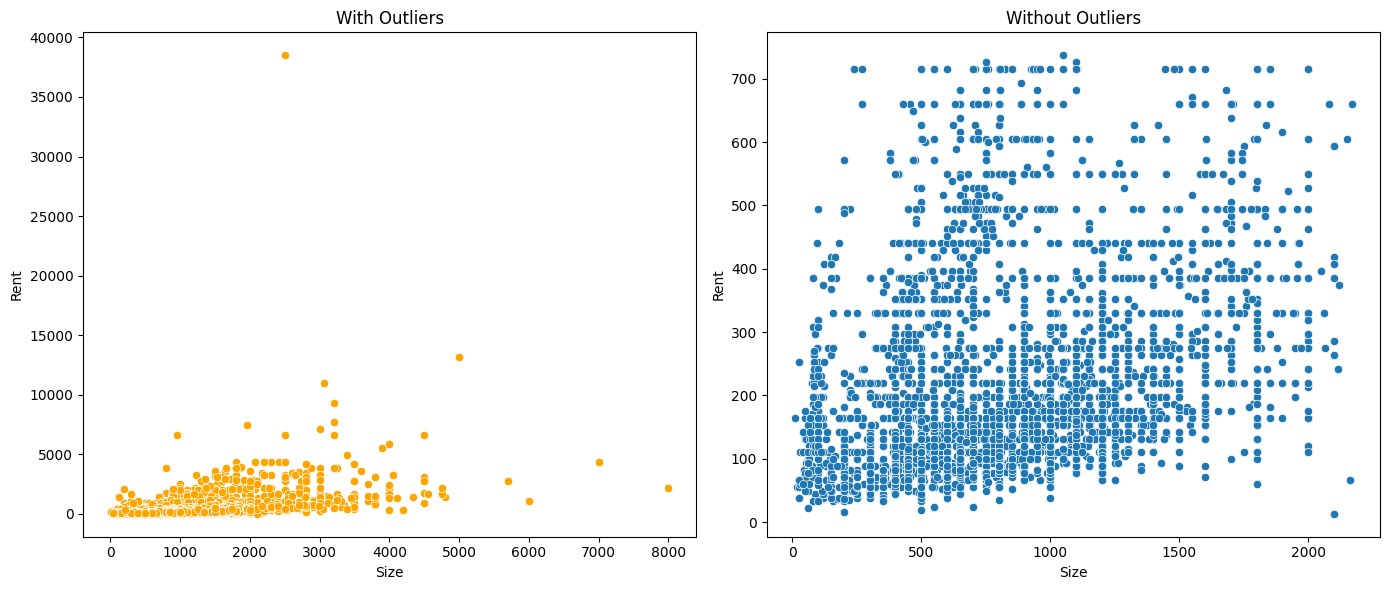

Mean rent without outliers is 207.53


In [16]:
# Converting INR to EUR
exchange_rate = 0.011
df["Rent"] = df["Rent"] * exchange_rate

plt.figure(figsize=(14, 6))
# Scatter plot with outliers
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x="Size", y="Rent", color="orange")
plt.title("With Outliers")


outlier_threshold = 1.5

# Calculate IQR for 'Rent'
Q1_rent = df["Rent"].quantile(0.25)
Q3_rent = df["Rent"].quantile(0.75)
IQR_rent = Q3_rent - Q1_rent
outliers_indices_rent = (df["Rent"] < Q1_rent - outlier_threshold * IQR_rent) | (
    df["Rent"] > Q3_rent + outlier_threshold * IQR_rent
)

# Calculate IQR for 'Size'
Q1_size = df["Size"].quantile(0.25)
Q3_size = df["Size"].quantile(0.75)
IQR_size = Q3_size - Q1_size
outliers_indices_size = (df["Size"] < Q1_size - outlier_threshold * IQR_size) | (
    df["Size"] > Q3_size + outlier_threshold * IQR_size
)
print(f'Mean rent with outliers is {df["Rent"].mean():.2f}')
# Remove outliers from both 'Rent' and 'Size'
df = df[~(outliers_indices_rent | outliers_indices_size)]

# Scatter plot without outliers
plt.subplot(1, 2, 2)
sns.scatterplot(x=df["Size"], y=df["Rent"])
plt.title("Without Outliers")

# Adjust and show layout
plt.tight_layout()
plt.show()


print(f'Mean rent without outliers is {df["Rent"].mean():.2f}')

### 3. Data Preprocessing

#### &emsp;*3.1. Extracting Floor Information*

&emsp;&emsp; - **Floor Number** and **Total Floors** \
&emsp;&emsp;&emsp; We identify the *Floor Number* using the first field of the split **Floor** column and determine the *Total Floors* using the last field. \
&emsp;&emsp;&emsp; The **Floor** column is then dropped as it is no longer needed.

&emsp;&emsp; - **Area Locality** \
&emsp;&emsp;&emsp; The detailed information in the **Area Locality** column has been removed. \
&emsp;&emsp;&emsp; This decision was made due to a large number of unique locality values, which could complicate the analysis without providing significant insights.

In [17]:
# First field of splitted column is usually number, basement, or ground
df["Floor Number"] = (
    df["Floor"]
    .str.split()
    .str[0]
    .apply(
        lambda x: -1 if "Lower" in x or "Upper" in x else (0 if "Ground" in x else x)
    )
)

# Convert the "Floor Number" column to numeric format, handling any potential errors
df["Floor Number"] = pd.to_numeric(df["Floor Number"], errors="coerce")


# Last field is total number of floors or there might be only Ground that way total number of floors is 0


df["Total Floors"] = df["Floor"].apply(
    lambda x: 0 if "Ground" in x else pd.to_numeric(x.split()[-1], errors="coerce")
)



# Dropping Area Locality


df = df.drop(["Area Locality", "Floor"], axis=1)

#### &emsp;*3.2. Reducing Dimensionality of **Area Type** and **City***

&emsp;&emsp; - **Area Type** \
&emsp;&emsp;&emsp; The **Area Type** column, offering insights into the nature of property areas, is streamlined for improved model interpretability. \
&emsp;&emsp;&emsp; Despite the presence of three area types, only *Carpet Area* significantly impacts rental values. To simplify the model, \
&emsp;&emsp;&emsp; we categorize properties as either having a *Carpet Area* or being *Not a Carpet Area*.

&emsp;&emsp; - **City** \
&emsp;&emsp;&emsp; In a similar vein, the **City** column undergoes a dimensionality reduction. With a focus on optimizing the model's interpretability, \
&emsp;&emsp;&emsp; we observe that *Mumbai* stands out as the sole city with distinct rental value characteristics.


In [18]:
df["Area Type"] = (
    df["Area Type"]
    .apply(lambda x: "Not a Carpet Area" if x != "Carpet Area" else "Carpet Area")
    .astype("category")
)


df["City"] = (
    df["City"]
    .apply(lambda x: "Not Mumbai" if x != "Mumbai" else "Mumbai")
    .astype("category")
)

#### &emsp;*3.3. Reducing Dimensionality of **Furnishing Status** and **Point of Contact***

&emsp;&emsp; - **Furnishing Status** \
&emsp;&emsp;&emsp; The **Furnishing Status** column is treated as an ordered categorical type. Properties are categorized as *Furnished*, *Semi-Furnished*, or *Unfurnished*.\
&emsp;&emsp;&emsp; Notably, *Furnished* properties tend to have the highest rental values, followed by *Semi-Furnished* and *Unfurnished* properties.

&emsp;&emsp; - **Point of Contact** \
&emsp;&emsp;&emsp; Similar to the approach taken with **City** and **Area Type**, we apply the same principle to the *Point of Contact* column. \
&emsp;&emsp;&emsp; Specifically, only instances where the point of contact is an *Agent* are considered separately due to their potential impact on the rental values.


In [19]:
# There is an inherit order for each category
df["Furnishing Status"] = df["Furnishing Status"].astype("category")
df["Furnishing Status"] = pd.Categorical(
    df["Furnishing Status"],
    categories=["Unfurnished", "Semi-Furnished", "Furnished"],
    ordered=True,
)

df["Point of Contact"] = (
    df["Point of Contact"]
    .apply(lambda x: "Not Contact Agent" if x != "Contact Agent" else "Contact Agent")
    .astype("category")
)

#### &emsp;*3.4. Dropping **Posted On**, **Tenant Preferred**, and **BHK***

&emsp;&emsp; - **Posted On** \
&emsp;&emsp;&emsp; The **Posted On** feature, indicating the date of property listings, has been excluded from the analysis. \
&emsp;&emsp;&emsp; Given that the dataset spans only four months in 2022, this temporal span is limited and, therefore, does not offer valuable information for predictive modeling.

&emsp;&emsp; - **Tenant Preferred** \
&emsp;&emsp;&emsp; Despite contributing a small number of features (3 out of 2), **Tenant Preferred** yields only a marginal ~2% increase in model performance. \
&emsp;&emsp;&emsp; The decision to omit this feature aligns with the objective of maintaining model simplicity without compromising predictive accuracy.

&emsp;&emsp; - **BHK** \
&emsp;&emsp;&emsp; The number of Bedrooms, Hall, and Kitchen (**BHK**) is found to be correlated with the property size. Given this correlation, \
&emsp;&emsp;&emsp; *BHK* provides limited additional information and is thus excluded from the features considered in the predictive modeling process.


In [20]:
df = df.drop(["Posted On", "Tenant Preferred", "BHK"], axis=1)

assert df.isna().sum().sum() == 0, "Dataset contains null values"

In [21]:
def size_vs_rent_per_feature(feature):
    # Scatter plot: Size vs. Rent colored by feature
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.scatterplot(
        x="Size",
        y="Rent",
        data=df,
        hue=feature,
        style=feature,
        alpha=0.75,
    )
    plt.title(f"Size vs. Rent by {feature}")

    # Bar plot: Rent per feature
    plt.subplot(1, 2, 2)
    sns.barplot(
        x=feature,
        y="Rent",
        data=df,
        errorbar=None,
        hue=feature,
        legend=None,
    )
    plt.title(f"Rent per {feature}")
    plt.tight_layout()

    plt.show()

### 4. Graphs

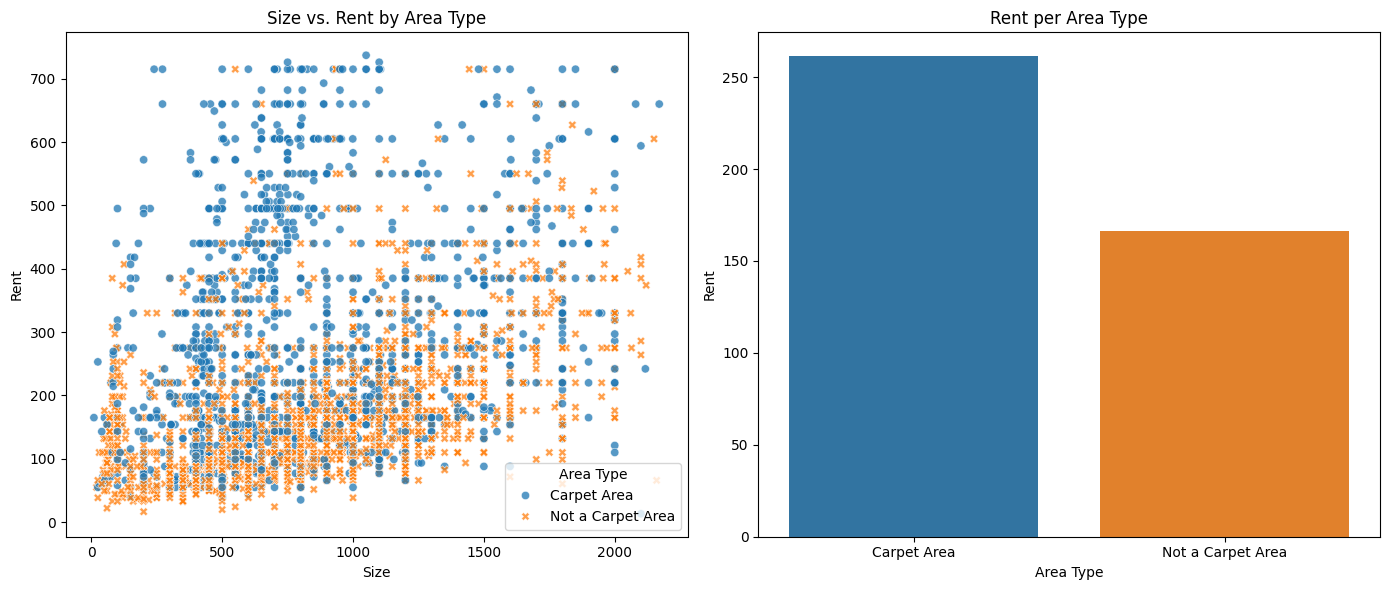

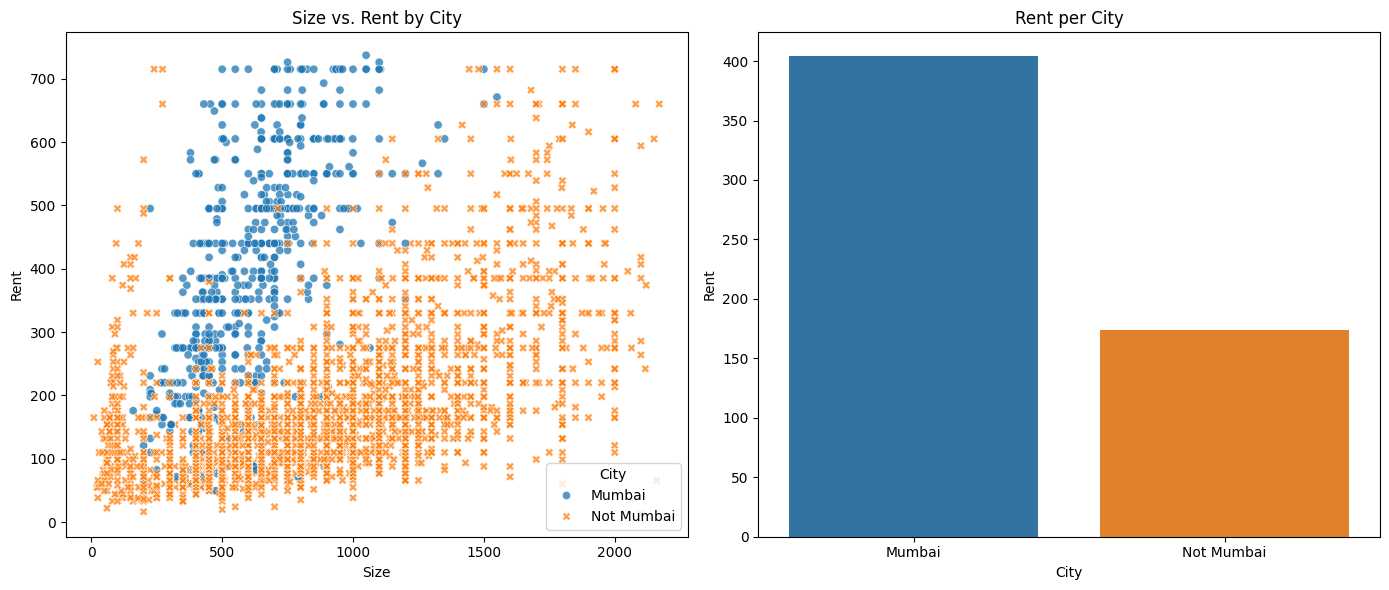

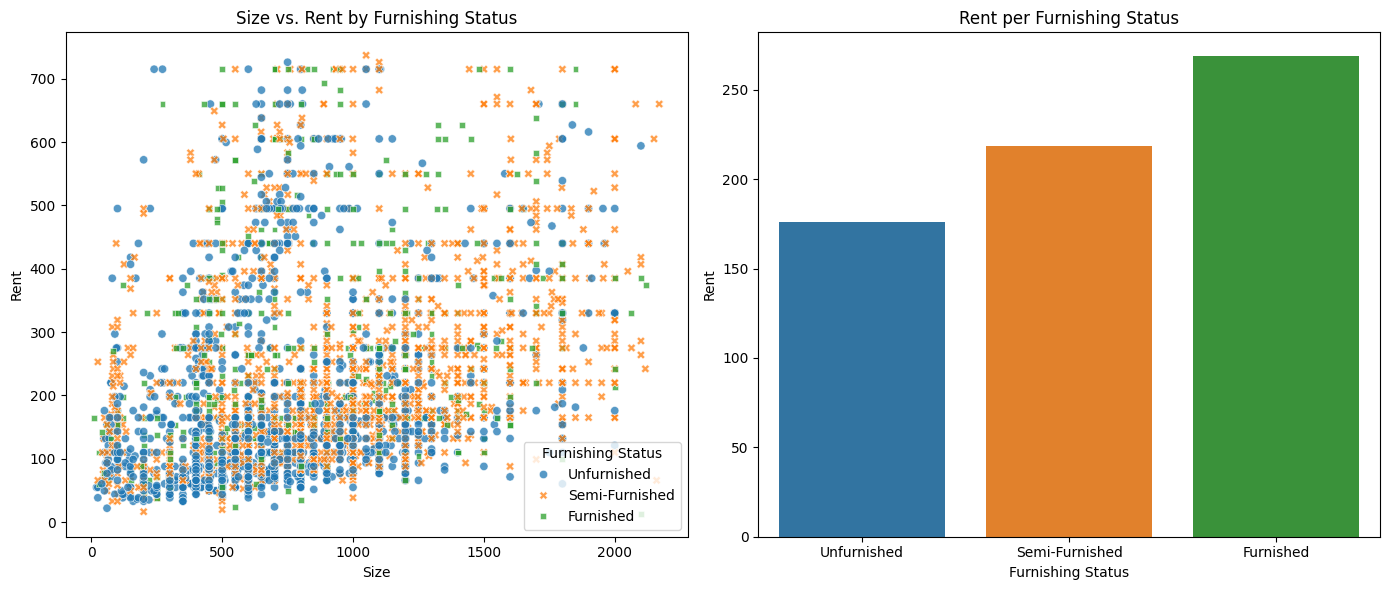

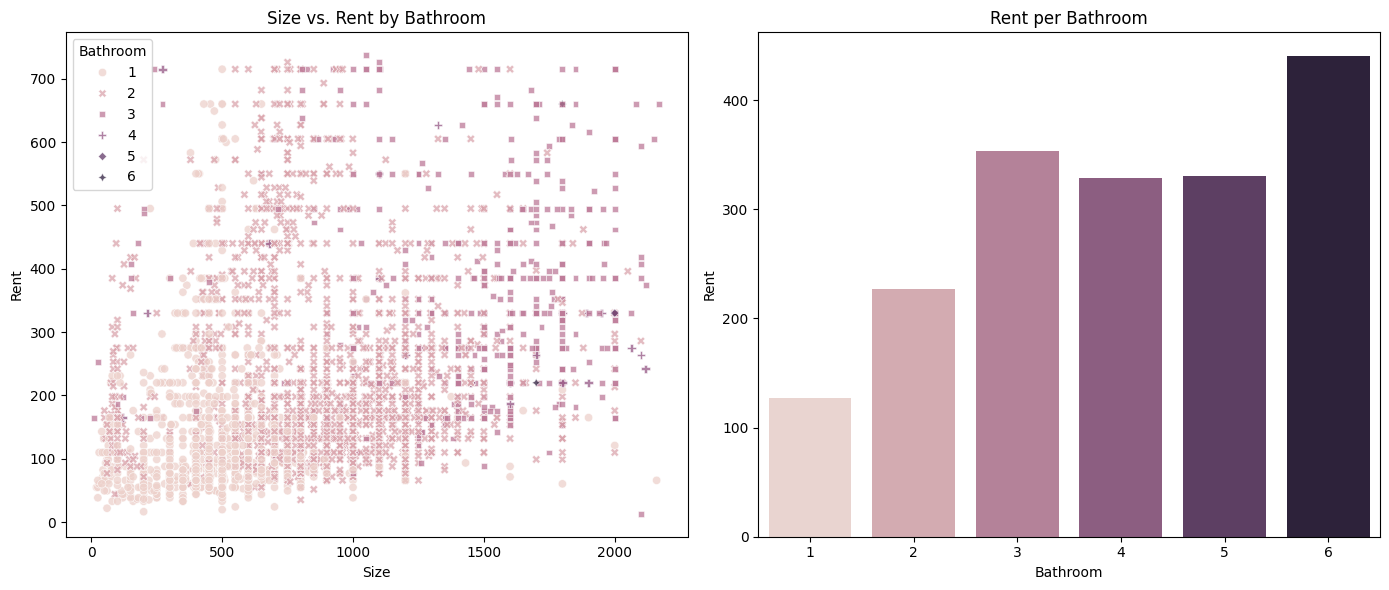

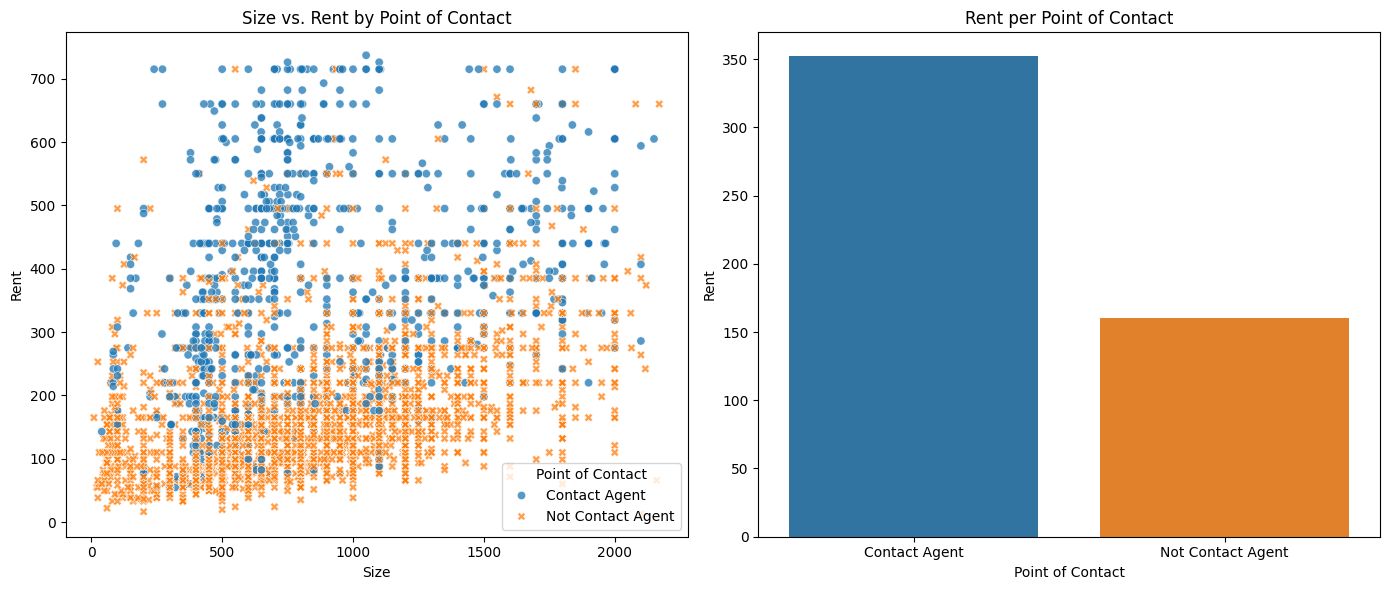

In [22]:
size_vs_rent_per_feature("Area Type")
size_vs_rent_per_feature("City")
size_vs_rent_per_feature("Furnishing Status")
size_vs_rent_per_feature("Bathroom")
size_vs_rent_per_feature("Point of Contact")

In [23]:
def RMSE(y_pred, y_test):
    rmae = mean_squared_error(y_pred, y_test) ** 0.5
    print(f"Root mean squared error is {rmae:.2f} EUR")


def R2_Score(y_pred, y_test):
    r2 = r2_score(y_pred, y_test)
    print(f"R2 score is {r2:.3f} ")

### 5. Preprocessing for Machine Learning

&emsp; - **Splitting Dataset:**\
&emsp;&emsp; We commence the preprocessing by dividing the dataset into two components: X, containing the features, and y, comprising the target variable.

&emsp; - **One-Hot Encoding Categorical Features:**\
&emsp;&emsp; Categorical features such as *Area Type*, *City*, and *Point of Contact* undergo one-hot encoding to transform them into a format suitable for machine learning algorithms. \
&emsp;&emsp; The drop-first strategy is employed to mitigate dummy variable multicollinearity.

&emsp; - **Encoding Furnishing Status:**\
&emsp;&emsp; Furnishing status, an ordered categorical feature, is encoded into numerical values.

&emsp; - **Train-Test Split:**\
&emsp;&emsp; The dataset is further partitioned into training and testing sets. This segregation ensures a reliable assessment of model performance.

In [24]:
X = df.drop(["Rent"], axis=1)
y = df[["Rent"]]

# One hot encoding for categorical features, dropping first because of dummy variable multicollinearity
X = pd.get_dummies(
    X,
    columns=["Area Type", "City", "Point of Contact"],
    drop_first=True,
    prefix="",
)

X["Furnishing Status"] = X["Furnishing Status"].cat.codes

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=123, test_size=0.20
)

X.head(7)

,Size,Furnishing Status,Bathroom,Floor Number,Total Floors,_Not a Carpet Area,_Not Mumbai,_Not Contact Agent
0,1100,0,2,0,0,True,True,True
1,800,1,1,1,3,True,True,True
2,1000,1,1,1,3,True,True,True
3,800,0,1,1,2,True,True,True
4,850,0,1,1,2,False,True,True
5,600,0,2,0,0,True,True,True
6,700,0,2,0,0,True,True,False


### 6. Simple Linear Regression Model

In [25]:
linregress_model = LinearRegression()
linregress_model = linregress_model.fit(X_train, y_train)

y_pred = linregress_model.predict(X_test)
RMSE(y_pred, y_test)
R2_Score(y_pred, y_test)

Root mean squared error is 88.02 EUR
R2 score is 0.514 


#### &emsp; *6.1. Linear Regression - Evaluation*

&emsp;&emsp;After fitting the Linear Regression model, the evaluation metrics indicate the following performance:

&emsp;&emsp; - **Root Mean Squared Error (RMSE):**\
&emsp;&emsp;&emsp; The RMSE stands at 88.02 EUR, reflecting the average deviation between predicted and actual rental values. This metric serves as an indicator of the model's accuracy in predicting rent prices.

&emsp;&emsp; - **R-Squared Score (R2):**\
&emsp;&emsp;&emsp; The R-squared score, representing the proportion of variance explained by the model, is observed to be 51.4%. While this indicates a moderate level of explanatory power, there remains room for improvement.

### 7. Random Forest Regressor

In [26]:
rf = RandomForestRegressor()

param_grid_rf = {
    "max_samples": [0.75],
    "max_depth": range(3, 10),
    "max_features": [3, 5, 7, 9],
    "n_estimators": range(100, 2001, 100),
    "min_samples_leaf": [2, 4, 6, 8, 10],
    "min_samples_split": [2, 4, 5],
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid_rf,
    cv=5,
    n_jobs=-1,
    n_iter=25,
    verbose=False,
    random_state=1,
)

random_search.fit(X_train, np.array(y_train).flatten())

rf_model = random_search.best_estimator_
rf_model.fit(X_train, np.array(y_train).flatten())

y_pred = rf_model.predict(X_test)
RMSE(y_pred, y_test)
R2_Score(y_pred, y_test)

Root mean squared error is 78.18 EUR
R2 score is 0.648 


#### &emsp; *7.1. Random Forest Regressor - Evaluation*

&emsp;&emsp; Utilizing Random Forest Regression, an extensive hyperparameter tuning process was conducted through randomized search, aiming to optimize model performance.\
&emsp;&emsp; The best-performing Random Forest model achieved the following results:

&emsp;&emsp; - **Root Mean Squared Error (RMSE):**\
&emsp;&emsp;&emsp; The RMSE is observed to be 78.18 EUR, indicating a reduced average deviation between predicted and actual rental values compared to the previous Linear Regression model.

&emsp;&emsp; - **R-Squared Score (R2):**\
&emsp;&emsp;&emsp; The R-squared score has improved to 64.8%, representing a notable increase in the proportion of variance explained by the model. 

### 8. Gradient Boosted Tree Regressor

In [27]:
xgb = XGBRegressor()

param_grid_xgb = {
    "learning_rate": [0.02, 0.1, 0.2],
    "n_estimators": range(100, 2001, 100),
    "max_depth": range(3, 10),
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid_xgb,
    n_iter=25,
    cv=5,
    n_jobs=-1,
    verbose=False,
    random_state=1,
)

random_search.fit(X_train, np.array(y_train).flatten())

xgb_model = random_search.best_estimator_

y_pred = xgb_model.predict(X_test)
RMSE(y_pred, y_test)
R2_Score(y_pred, y_test)

Root mean squared error is 78.55 EUR
R2 score is 0.647 


#### &emsp; *8.1. Model Evaluation - XGBoost Regression*

&emsp;&emsp; Applying Gradient Boosted Tree Regression with XGBoost, the optimized model demonstrated the following evaluation metrics:

&emsp;&emsp; - **Root Mean Squared Error (RMSE):**\
&emsp;&emsp;&emsp; The RMSE is calculated at 78.55 EUR, representing the average deviation between predicted and actual rental values.

&emsp;&emsp; - **R-Squared Score (R2):**\
&emsp;&emsp;&emsp; The R-squared score stands at 0.647, indicating the proportion of variance explained by the model.

&emsp;&emsp; It's noteworthy that, while the XGBoost model's performance is slightly below that of the Random Forest model, it offers a notable advantage in terms of computational efficiency.\
&emsp;&emsp; The XGBoost model achieved these results in approximately 17 seconds, contrasting with the Random Forest's 52 seconds.\
&emsp;&emsp; This trade-off between model performance and speed may be a crucial consideration in certain applications, where faster predictions are desired.

### 9. Stacked Ensemble Model

In [28]:
stacked_model = StackingRegressor(
    estimators=[("linear", linregress_model), ("xgb", xgb_model), ("rf", rf_model)],
    final_estimator=Lasso(),
)

# Fit the stacking model on the training data
stacked_model.fit(X_train, np.array(y_train).flatten())

# Predict on the test set using the stacking model
y_pred = stacked_model.predict(X_test)

rent_predict_error = RMSE(y_pred, y_test)

Root mean squared error is 78.13 EUR


#### &emsp; *9.1. Stacked Ensemble Model Evaluation*


&emsp;&emsp; Constructing a stacked ensemble model, comprised of a Linear Regression model, an XGBoost regressor, and a Random Forest regressor, with Lasso regression as the final estimator.

&emsp;&emsp; **Model Performance Metrics:**

&emsp;&emsp; - **Root Mean Squared Error (RMSE):**\
&emsp;&emsp;&emsp; The RMSE is calculated at 78.13 EUR, representing the average deviation between predicted and actual rental values.



### 10. Conclusion

&emsp; In the pursuit of enhancing predictive accuracy, we embarked on constructing a stacked ensemble model, amalgamating a linear regression model, an XGBoost regressor, and a Random Forest regressor with Lasso regression as the final estimator.

&emsp; **Model Evaluation Insights:**

&emsp; Despite the concerted effort to leverage the strengths of diverse algorithms, the stacked ensemble model did not yield a substantial improvement over individual models. \
&emsp; The minimal gain in predictive performance did not justify the increased complexity introduced by stacking.

&emsp; **Considerations:**

&emsp; - The trade-off between model interpretability and performance must be carefully considered. In this instance, the marginal gain did not outweigh the added complexity. \
&emsp; - Computational efficiency and interpretability were key factors in the decision-making process.

&emsp; While the stacked ensemble did not prove to be significantly advantageous in this context, the exploration was worthwhile, providing valuable insights into the interplay of different models.

&emsp; In conclusion, the evaluation of models revealed the XGBoostRegressor as a compelling choice for this particular task. \
&emsp; Despite a marginally worse Root Mean Squared Error (RMSE) and R-squared score compared to the Random Forest model, the XGBoostRegressor was almost *3 times faster*.

&emsp; It's important to note that the outcome could be influenced by the specific characteristics of the dataset. \
&emsp; Further refinement of data selection and preprocessing may uncover additional optimization opportunities.
